<h1><center>CAN A COMPUTER RECOGNIZE SIGN LANGUAGE?</h1></center>

## Project Problem and Hypothesis

BACKGROUND:  Sign language is a language that uses hand motions to represent a word or concept.  Sign language is not easily understood by hearing people with no background in sign language.  If there were a way to translate sign language motions into English, this would greatly increase the ability of the hearing and hard-of-hearing to understand each other.

OBJECTIVE:  Can we use motion sensor data to translate signs in Australian sign language into written English?

HYPOTHESIS:  Given motion sensor data, a machine learning algorithm can identify the word "what" (classification problem).  

SUCCESS METRIC:  Confusion matrix (precision and recall) for correct classification of six question words.  The optimal Area Under Curve (AUC) = 1.


In [32]:
import os
import fnmatch

import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)

from sklearn import preprocessing, linear_model, model_selection, metrics


  # PLOTTING
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

In [2]:
    #this function reads in all of the file names that have "signname" in them within any folder inside
    # /signs  which is where all the data are
def read_all_files(sign_name):
        df=[[]]
        data=pd.DataFrame(df)
        for root, dirs, files in os.walk('/Users/seanmcghee/Desktop/DS-SF-34-MyStuff/Australian-Sign-Language/signs'):
             for fname in files:
                if sign_name in fname:
                    temp = pd.read_csv(os.path.join(root, fname),header=None)
                    temp_df=pd.DataFrame(temp)
                    temp_df['signr_sess_test']=root[root.rfind('/')+1:]+"-"+fname[-6:-5]
                    temp_df.rename(columns = {0: 'x',
                        1: 'y',
                        2: 'z',
                        3: 'roll',
                        4: 'pitch',
                        5: 'yaw',
                        6: 'thumb_bend',
                        7: 'pointer_bend',
                        8: 'middle_bend',
                        9: 'ring_bend',
                        10: 'pinky_bend'}, inplace = True)
                    temp_df['num_frames'] = temp_df.groupby(['signr_sess_test'])['x'].transform('count').astype(int)
                    data=pd.concat([data,temp_df],axis=0, ignore_index=True)
            # get rid of first row which is blank
        data.drop(data.head(1).index, inplace=True)
        data.drop([11,12,13,14],axis=1, inplace=True)
        return data
    
    
    # this function takes the difference between the 25th and 75th percentiles of a field
def get_diff(df,field):
        temp_75 = df.groupby(['signr_sess_test'])[[field]].agg(lambda g: np.percentile(g,75))
        temp_75.rename(columns = {field: field+'_75'}, inplace=True)
        temp_25 = what.groupby(['signr_sess_test'])[[field]].agg(lambda g: np.percentile(g,25))
        temp_25.rename(columns = {field: field+'_25'}, inplace=True)
        temp_25.head(5)
        df_features = pd.concat([temp_25,temp_75], axis=1)
        df_features[field+'_diff']=df_features[field+'_75']-df_features[field+'_25']
        return df_features    
    

    # create differences and put them in one data frame
def concat_diffs(df,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11):
        temp = get_diff(df,f1)
        temp = pd.concat([temp,get_diff(df,f2)], axis=1)
        temp = pd.concat([temp,get_diff(df,f3)], axis=1)
        temp = pd.concat([temp,get_diff(df,f4)], axis=1)
        temp = pd.concat([temp,get_diff(df,f5)], axis=1)
        temp = pd.concat([temp,get_diff(df,f6)], axis=1)
        temp = pd.concat([temp,get_diff(df,f7)], axis=1)
        temp = pd.concat([temp,get_diff(df,f8)], axis=1)
        temp = pd.concat([temp,get_diff(df,f9)], axis=1)
        temp = pd.concat([temp,get_diff(df,f10)], axis=1)
        temp = pd.concat([temp,get_diff(df,f11)], axis=1)
        temp.head(5)
        return temp

    # this function creates box plots of all of the differences
def plot_diffs(df,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11):
        fig = plt.figure(figsize=(14,14))
        ax1 = fig.add_subplot(431)
        ax1.boxplot(df[ f1 ])
        plt.ylabel(f1)
        ax2 = fig.add_subplot(432)
        ax2.boxplot(df[ f2 ])
        plt.ylabel(f2)
        ax3 = fig.add_subplot(433)
        ax3.boxplot(df[ f3 ])
        plt.ylabel(f3)
        ax4 = fig.add_subplot(434)
        ax4.boxplot(df[ f4 ])
        plt.ylabel(f4)
        ax5 = fig.add_subplot(435)
        ax5.boxplot(df[ f5 ])
        plt.ylabel(f5)
        ax6 = fig.add_subplot(436)
        ax6.boxplot(df[ f6 ])
        plt.ylabel(f6)
        ax7 = fig.add_subplot(437)
        ax7.boxplot(df[ f7 ])
        plt.ylabel(f7)
        ax8 = fig.add_subplot(438)
        ax8.boxplot(df[ f8 ])
        plt.ylabel(f8)
        ax9 = fig.add_subplot(439)
        ax9.boxplot(df[ f9 ])
        plt.ylabel(f9)
        ax10 = fig.add_subplot(4,3,10)
        ax10.boxplot(df[ f10 ])
        plt.ylabel(f10)
        ax11 = fig.add_subplot(4,3,11)
        ax11.boxplot(df[ f11 ])
        plt.ylabel(f11)
        


## WHAT

In [3]:
what = read_all_files("what")
what.head(5)

,x,y,z,roll,pitch,yaw,thumb_bend,pointer_bend,middle_bend,ring_bend,pinky_bend,signr_sess_test,num_frames
1,-0.007812,0.000000,0.0,0.000000,-1.0,-1.0,0.25,0.50,0.50,0.75,0.75,adam1-0,49.0
2,0.000000,-0.015625,0.0,0.000000,-1.0,-1.0,0.25,0.50,0.50,0.75,0.75,adam1-0,49.0
3,-0.007812,0.000000,0.0,0.000000,-1.0,-1.0,0.25,0.25,0.75,0.75,0.75,adam1-0,49.0
4,0.000000,0.007812,0.0,0.000000,-1.0,-1.0,0.25,0.00,0.75,0.75,0.75,adam1-0,49.0
5,0.007812,0.000000,0.0,0.083333,-1.0,-1.0,0.25,0.00,0.75,0.75,0.75,adam1-0,49.0


In [4]:
what_features = concat_diffs(what,'x','y','z', \
                             'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
what_features['is_what']=1
what_features.head(5)


,x_25,x_75,x_diff,y_25,y_75,y_diff,z_25,z_75,z_diff,pitch_25,...,middle_bend_25,middle_bend_75,middle_bend_diff,ring_bend_25,ring_bend_75,ring_bend_diff,pinky_bend_25,pinky_bend_75,pinky_bend_diff,is_what
signr_sess_test,,,,,,,,,,,,,,,,,,,,,
adam1-0,-0.117188,0.000000,0.117188,0.023438,0.562500,0.539062,-0.015625,0.0,0.015625,-1.0,...,0.25,0.50,0.25,0.75,0.75,0.00,0.75,0.75,0.00,1
adam1-1,-0.117188,-0.015625,0.101562,0.001953,0.466797,0.464844,-0.054688,0.0,0.054688,-1.0,...,0.25,0.25,0.00,0.75,0.75,0.00,0.75,0.75,0.00,1
adam2-0,-0.054688,0.029297,0.083985,0.050781,0.765625,0.714844,-0.015625,0.0,0.015625,-1.0,...,0.75,0.75,0.00,0.00,0.75,0.75,0.00,0.75,0.75,1
adam2-1,-0.005859,0.046875,0.052734,-0.019532,0.701172,0.720703,-0.039062,0.0,0.039062,-1.0,...,0.25,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
adam2-2,-0.078125,0.015625,0.093750,0.070312,0.820312,0.750000,-0.031250,0.0,0.031250,-1.0,...,0.25,0.50,0.25,0.00,0.00,0.00,0.00,0.00,0.00,1


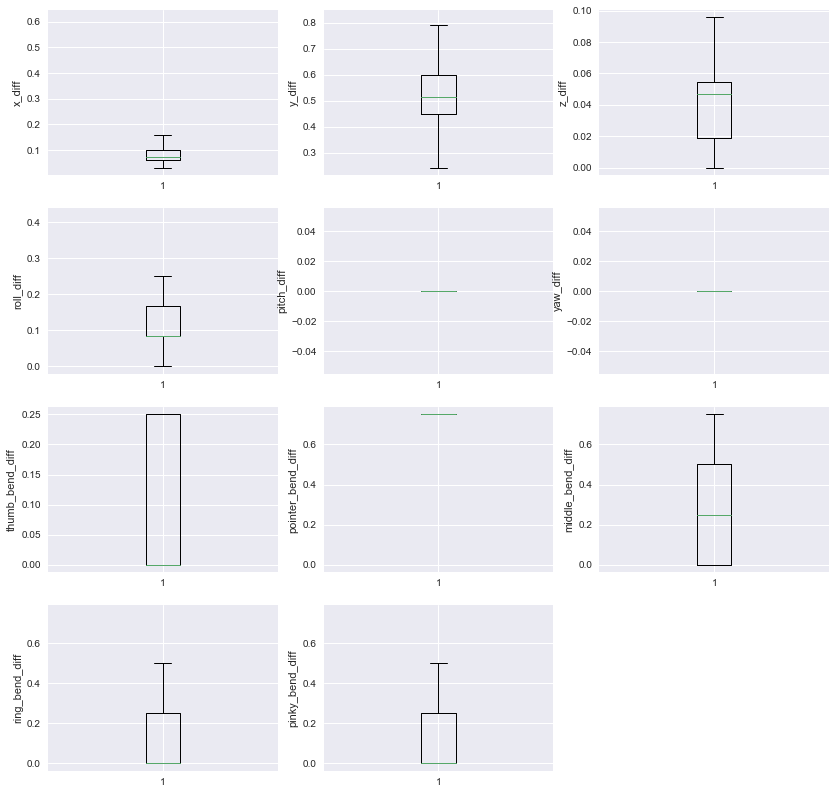

In [5]:
plot_diffs(what_features,'x_diff','y_diff','z_diff','roll_diff','pitch_diff','yaw_diff', \
           'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff','pinky_bend_diff')

## WHEN

In [6]:
when = read_all_files("when")
when_features = concat_diffs(when,'x','y','z', \
                             'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
when_features['is_what']=0
#plot_diffs(when_features,'x_diff','y_diff','z_diff','roll_diff','pitch_diff','yaw_diff', \
#          'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff','pinky_bend_diff')

## WHERE

In [7]:
where = read_all_files("where")
where_features = concat_diffs(where,'x','y','z', \
                             'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
where_features['is_what']=0


## WHICH

In [8]:
which = read_all_files("which")
which_features = concat_diffs(which,'x','y','z', \
                             'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
which_features['is_what']=0


## WHO

In [9]:
who = read_all_files("who")
who_features = concat_diffs(who,'x','y','z', \
                             'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
who_features['is_what']=0


## WHY

In [10]:
why = read_all_files("why")
why_features = concat_diffs(why,'x','y','z', \
                             'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
why_features['is_what']=0


# Can we distinguish between "What" and "Not What"?

In [11]:
df=pd.concat([what_features,when_features,where_features,which_features,who_features,why_features]).sort_index()
df=df[['x_diff','y_diff','z_diff','roll_diff','pitch_diff','yaw_diff', \
           'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff','pinky_bend_diff',
      'is_what']]
df.head()

,x_diff,y_diff,z_diff,roll_diff,pitch_diff,yaw_diff,thumb_bend_diff,pointer_bend_diff,middle_bend_diff,ring_bend_diff,pinky_bend_diff,is_what
signr_sess_test,,,,,,,,,,,,
adam1-0,0.117188,0.539062,0.015625,0.083333,0.0,0.0,0.00,0.75,0.25,0.00,0.00,1
adam1-0,0.156250,0.054687,0.031250,0.333333,0.0,0.0,-0.25,0.75,0.50,0.00,0.00,0
adam1-0,0.125000,0.656250,0.027343,0.291666,0.0,0.0,0.00,0.75,0.25,0.00,0.00,0
adam1-0,0.132813,0.242187,0.015625,0.000000,0.0,0.0,-0.25,0.75,0.50,-0.25,-0.25,0
adam1-0,0.093750,0.367187,0.015625,0.083333,0.0,0.0,-0.25,0.75,0.25,-0.25,-0.25,0


In [12]:
   # what appears 17% of the time
df.is_what.mean()

0.16666666666666666

In [13]:
   # very little correlation, except for ring_bend_diff and pinky_bend_diff
df.corr()

,x_diff,y_diff,z_diff,roll_diff,pitch_diff,yaw_diff,thumb_bend_diff,pointer_bend_diff,middle_bend_diff,ring_bend_diff,pinky_bend_diff,is_what
x_diff,1.000000,0.240186,-0.174465,-0.051725,NaN,NaN,-0.223739,-0.155452,0.179583,0.053242,0.053242,0.083551
y_diff,0.240186,1.000000,0.296291,-0.058399,NaN,NaN,0.056901,-0.023523,-0.022529,-0.135501,-0.135501,0.331228
z_diff,-0.174465,0.296291,1.000000,0.162312,NaN,NaN,-0.192248,0.036669,0.061988,0.006336,0.006336,0.006840
roll_diff,-0.051725,-0.058399,0.162312,1.000000,NaN,NaN,0.031833,0.103561,0.172257,0.114366,0.114366,-0.265279
pitch_diff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yaw_diff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thumb_bend_diff,-0.223739,0.056901,-0.192248,0.031833,NaN,NaN,1.000000,0.158050,-0.178465,-0.080826,-0.080826,0.196259
pointer_bend_diff,-0.155452,-0.023523,0.036669,0.103561,NaN,NaN,0.158050,1.000000,0.032843,0.018529,0.018529,0.030498
middle_bend_diff,0.179583,-0.022529,0.061988,0.172257,NaN,NaN,-0.178465,0.032843,1.000000,0.395309,0.395309,-0.135202
ring_bend_diff,0.053242,-0.135501,0.006336,0.114366,NaN,NaN,-0.080826,0.018529,0.395309,1.000000,1.000000,-0.115068


In [14]:
df.isnull().sum().sum()

0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11af0a310>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11d2aa850>]], dtype=object)

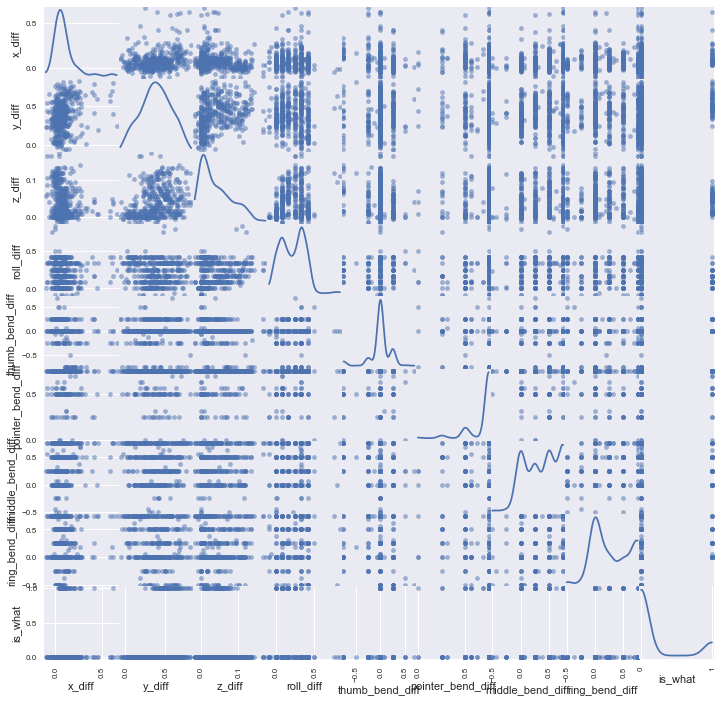

In [15]:
    # took out pitch and yaw because always 0
pd.tools.plotting.scatter_matrix(
    df[ ['x_diff','y_diff','z_diff', 'roll_diff',\
         #'pitch_diff','yaw_diff', \
           'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff', \
           #,'pinky_bend_diff', \
      'is_what'] ],
    diagonal = 'kde', s = 75, figsize = (12, 12))

In [16]:
df.groupby('is_what').mean()

,x_diff,y_diff,z_diff,roll_diff,pitch_diff,yaw_diff,thumb_bend_diff,pointer_bend_diff,middle_bend_diff,ring_bend_diff,pinky_bend_diff
is_what,,,,,,,,,,,
0,0.080480,0.352104,0.040737,0.235357,0.0,0.0,-0.025893,0.690000,0.394643,0.274821,0.274821
1,0.104464,0.526060,0.041490,0.125893,0.0,0.0,0.085714,0.700893,0.283929,0.161607,0.161607


## Logistic Regression with Statsmodel

In [17]:
import statsmodels.api as sm

X = df[['x_diff','y_diff','z_diff', 'roll_diff',\
           'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff']]
Y = df[['is_what']]

model = sm.Logit(Y,X)
result = model.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.321921
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                is_what   No. Observations:                  420
Model:                          Logit   Df Residuals:                      412
Method:                           MLE   Df Model:                            7
Date:                Sun, 18 Jun 2017   Pseudo R-squ.:                  0.2855
Time:                        11:15:08   Log-Likelihood:                -135.21
converged:                       True   LL-Null:                       -189.24
                                        LLR p-value:                 2.321e-20
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
x_diff               -1.2222      1.946     -0.628      0.530      -5.037       2.592
y_diff  

In [18]:
   # take out x_diff
X = df[['y_diff','z_diff', 'roll_diff',\
           'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff']]
Y = df[['is_what']]

model = sm.Logit(Y,X)
result = model.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.322400
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                is_what   No. Observations:                  420
Model:                          Logit   Df Residuals:                      413
Method:                           MLE   Df Model:                            6
Date:                Sun, 18 Jun 2017   Pseudo R-squ.:                  0.2844
Time:                        11:15:08   Log-Likelihood:                -135.41
converged:                       True   LL-Null:                       -189.24
                                        LLR p-value:                 6.309e-21
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
y_diff                5.8019      1.028      5.645      0.000       3.787       7.816
z_diff  

In [19]:
   # take out ring_bend_diff  now all statistically significant
X = df[['y_diff', 'z_diff','roll_diff',\
           'thumb_bend_diff','pointer_bend_diff','middle_bend_diff',]]
Y = df[['is_what']]

model = sm.Logit(Y,X)
result = model.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.323074
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                is_what   No. Observations:                  420
Model:                          Logit   Df Residuals:                      414
Method:                           MLE   Df Model:                            5
Date:                Sun, 18 Jun 2017   Pseudo R-squ.:                  0.2830
Time:                        11:15:08   Log-Likelihood:                -135.69
converged:                       True   LL-Null:                       -189.24
                                        LLR p-value:                 1.688e-21
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
y_diff                5.7671      1.023      5.640      0.000       3.763       7.771
z_diff  

## Logistic Regression with scikit learn

### Feature Selection

In [25]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X = df[['x_diff','y_diff','z_diff','roll_diff', \
                 'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff', \
                 ]]
Y = df['is_what']

model = LogisticRegression()
   # chose 6 variables:  x_diff, y_diff, roll_diff, thumb_bend_diff, middle_bend_diff, ring_bend_diff
    # statsmodel agrees
rfe = RFE(model,6)
rfe = rfe.fit(X,Y)
print rfe.support_
print rfe.ranking_

[ True  True False  True  True False  True  True]
[1 1 3 1 1 2 1 1]


In [26]:
from sklearn import linear_model

X = df[['x_diff','y_diff','z_diff','roll_diff', \
                 'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff', \
                 ]]
Y = df['is_what']

model = linear_model.LogisticRegression().fit(X, Y)

print model.intercept_
print zip(X.columns, model.coef_[0])

[-1.91872388]
[('x_diff', 0.45076409089645231), ('y_diff', 3.2225053094116083), ('z_diff', 0.14719877337400852), ('roll_diff', -2.9617611937260153), ('thumb_bend_diff', 2.0788544526370067), ('pointer_bend_diff', -0.25609353122411821), ('middle_bend_diff', -0.8421031624033789), ('ring_bend_diff', -0.33772847344594331)]


In [27]:
   #  what appears 17% of the time, so this score is not much better than always choosing Not What.
    # 0.83809523809523812 
model.score(X,Y)

0.83809523809523812

## Cross validation

In [28]:
from sklearn import model_selection
   # 0.83095238095238089 if take all variables
model_selection.cross_val_score(model, X , Y, cv= 5).mean()


0.83095238095238089

## Model Performance

In [30]:
Y_hat = model.predict(X)

pd.crosstab(Y,
    Y_hat,
    rownames = ['Hypothesized Class'],
    colnames = ['True Class'])

True Class,0,1
Hypothesized Class,,
0,349,1
1,67,3


In [33]:
   # normalization and grid search
scaler = preprocessing.MinMaxScaler().fit(X)

X = pd.DataFrame(scaler.transform(X), columns = X.columns)

gs = model_selection.GridSearchCV(
    estimator = linear_model.LogisticRegression(),
    param_grid = {'C': np.logspace(-10, 10, 21), 'penalty': ['l1']},
    cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 3)
)

gs.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1'], 'C': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [34]:
gs.best_params_

{'C': 100.0, 'penalty': 'l1'}

In [35]:
gs.best_estimator_

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
model = gs.best_estimator_.fit(X, Y)
print model.intercept_
print zip(X.columns, model.coef_[0])

[-8.83603748]
[('x_diff', 0.87160684123412469), ('y_diff', 7.5142623507375825), ('z_diff', 2.4597486327178437), ('roll_diff', -9.0331465248806158), ('thumb_bend_diff', 8.5659524739514072), ('pointer_bend_diff', 1.0562048359562952), ('middle_bend_diff', -1.8631831962639211), ('ring_bend_diff', -0.27758253043725756)]
